In [1]:
import numpy as np
import matplotlib.cm as cmap
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *

# FUNCTIONS

In [2]:
def get_labeled_data(picklename, bTrain = True):
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    if os.path.isfile('%s.pickle' % picklename):
        data = pickle.load(open('%s.pickle' % picklename, 'rb'))
    else:
        # Open the images with gzip in read binary mode
        if bTrain:
            images = open(MNIST_data_path + 'train-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 'train-labels.idx1-ubyte','rb')
        else:
            images = open(MNIST_data_path + 't10k-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 't10k-labels.idx1-ubyte','rb')
        # Get metadata for images
        images.read(4)  # skip the magic_number
        number_of_images = unpack('>I', images.read(4))[0]
        rows = unpack('>I', images.read(4))[0]
        cols = unpack('>I', images.read(4))[0]
        # Get metadata for labels
        labels.read(4)  # skip the magic_number
        N = unpack('>I', labels.read(4))[0]

        if number_of_images != N:
            raise Exception('number of labels did not match the number of images')
        # Get the data
        x = np.zeros((N, rows, cols), dtype=np.uint8)  # Initialize numpy array
        y = np.zeros((N, 1), dtype=np.uint8)  # Initialize numpy array
        for i in range(N):
            if i % 1000 == 0:
                print("i: %i" % i)
            x[i] = [[unpack('>B', images.read(1))[0] for unused_col in range(cols)]  for unused_row in range(rows) ]
            y[i] = unpack('>B', labels.read(1))[0]

        data = {'x': x, 'y': y, 'rows': rows, 'cols': cols}
        pickle.dump(data, open("%s.pickle" % picklename, "wb"), encoding='bytes')
    return data

In [3]:
def get_matrix_from_file(fileName):
    offset = 4
    if fileName[-4-offset] == 'X':
        n_src = n_input
    else:
        if fileName[-3-offset]=='e':
            n_src = n_e
        else:
            n_src = n_i
    if fileName[-1-offset]=='e':
        n_tgt = n_e
    else:
        n_tgt = n_i
    readout = np.load(fileName)
    print(readout.shape, fileName)
    value_arr = np.zeros((n_src, n_tgt))
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def get_2d_input_weights():       # (n_in*n_in, n_e*n_e) into (n_in*n_e, n_in*n_e)
    name = 'XeAe'
    # weight_matrix = np.zeros((n_input, n_e))   # (784, 225) from one pixel to all neurons in 15*15 grid
    n_e_sqrt = int(np.sqrt(n_e))
    n_in_sqrt = int(np.sqrt(n_input))
    num_values_col = n_e_sqrt*n_in_sqrt        # 28*15 = 420
    num_values_row = num_values_col
    rearranged_weights = np.zeros((num_values_col, num_values_row))           # (420,420) 
    connMatrix = np.zeros((n_input, n_e))                                     # (784, 225)
    connMatrix[connections[name].i, connections[name].j] = connections[name].w   # random values ar begining
    weight_matrix = np.copy(connMatrix)
    
    for i in range(n_e_sqrt):
        for j in range(n_e_sqrt):
                rearranged_weights[i*n_in_sqrt : (i+1)*n_in_sqrt, j*n_in_sqrt : (j+1)*n_in_sqrt] = weight_matrix[:, i + j*n_e_sqrt].reshape((n_in_sqrt, n_in_sqrt))
    return rearranged_weights

In [5]:
def plot_2d_input_weights(fig_num):
    name = 'XeAe'
    weights = get_2d_input_weights()
    fig = figure(fig_num, figsize = (10, 10))
    im2 = imshow(weights, interpolation = "nearest", vmin = 0, vmax = wmax_ee, cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('weights of connection' + name)
    fig.canvas.draw()
    return im2, fig

In [6]:
def update_2d_input_weights(im, fig):
    weights = get_2d_input_weights()
    im.set_array(weights)
    fig.canvas.draw()
    return im

In [7]:
def plot_performance(fig_num):
    num_evaluations = int(num_examples/update_interval)
    time_steps = range(0, num_evaluations)
    performance = np.zeros(num_evaluations)
    fig = figure(fig_num, figsize = (5, 5))
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #my_cmap
    ylim(ymax = 100)
    title('Classification performance')
    fig.canvas.draw()
    return im2, performance, fig_num, fig

In [8]:
def update_performance_plot(im, performance, current_example_num, fig):
    performance = get_current_performance(performance, current_example_num)
    im.set_ydata(performance)
    fig.canvas.draw()
    return im, performance

In [9]:
def normalize_weights():
    for connName in connections:                                             # XeAe, AeAi, AiAe
        if connName[1] == 'e' and connName[3] == 'e':                        # only normalize XeAe
            len_source = len(connections[connName].source)                   # 784 = 28*28
            len_target = len(connections[connName].target)                   # 225 = 15*15
            connection = np.zeros((len_source, len_target))                  # (784,225)
            connection[connections[connName].i, connections[connName].j] = connections[connName].w
            temp_conn = np.copy(connection)                                  # why make temp ???????????
            colSums = np.sum(temp_conn, axis = 0)
            colFactors = weight['ee_input']/colSums                         # 78.0/value of each n_e neuron sum
            for j in range(n_e):                  # for each n_e
                temp_conn[:,j] *= colFactors[j]   # weight = (weight*78.0) / (sum of input weights for each n_e neuron)
            connections[connName].w = temp_conn[connections[connName].i, connections[connName].j]

In [10]:
def get_new_assignments(result_monitor, input_numbers): # assign each n_e neuron, most spiking number
    # input_numbers = array of zeros with len of update interval
    # result_monitor = np.zeros((update_interval,n_e))     (400, 225) Ae
    assignments = np.zeros(n_e)                   # (225,)
    input_nums = np.asarray(input_numbers)        # convers list into numpy.ndarray
    maximum_rate = [0] * n_e 
    for j in range(10):
        num_assignments = len(np.where(input_nums == j)[0])
        if num_assignments > 0:
            rate = np.sum(result_monitor[input_nums == j], axis = 0) / num_assignments
        for i in range(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j
    return assignments

In [11]:
def save_connections(ending=''):         # save only XeAe connections
    print('save connections')
    connName = 'XeAe'
    conn = connections[connName]
    connListSparse = zip(conn.i[:], conn.j[:], conn.w[:])
    print(connListSparse)
    np.save('./experiment/weights/' + connName + ending, connListSparse)

In [12]:
def save_theta(ending=''):             # save only A populations
    print('save theta')
    np.save('./experiment/weights/theta_A' + ending, neuron_groups['Ae'].theta)

In [13]:
def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 10
    num_assignments = [0] * 10
    for i in range(10):
        num_assignments[i] = len(np.where(assignments == i)[0])
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
    return np.argsort(summed_rates)[::-1]

In [14]:
def get_current_performance(performance, current_example_num):
    current_evaluation = int(current_example_num/update_interval)
    start_num = current_example_num - update_interval
    end_num = current_example_num
    difference = outputNumbers[start_num:end_num, 0] - input_numbers[start_num:end_num]
    correct = len(np.where(difference == 0)[0])
    performance[current_evaluation] = correct / float(update_interval) * 100
    return performance

# CODE

load MINST data set

In [15]:
MNIST_data_path = './MINST/'
np.random.seed(0)

In [16]:
start = time.time()
training = get_labeled_data(MNIST_data_path + 'training')
end = time.time()
print('time needed to load training set:', end - start)

start = time.time()
testing = get_labeled_data(MNIST_data_path + 'testing', bTrain = False)
end = time.time()
print('time needed to load test set:', end - start)

time needed to load training set: 0.3612086772918701
time needed to load test set: 0.05681610107421875


limit MINST dataset

In [17]:
dataset_size = 1

training['x'] = training['x'][:dataset_size]
training['y'] = training['y'][:dataset_size]

# testing

set parameters

In [18]:
weight_path = './experiment/random'       # because weights are random values at begining
num_examples = dataset_size * 100
#use_testing_set = False
#do_plot_performance = True
#record_spikes = True
#ee_STDP_on = True

n_input = 784                            # input 28*28 grid
n_e = 16                                # 15*15 grid of neurons
n_i = n_e

single_example_time = 0.35 * second           # run times per example
resting_time = 0.15 * second                  # # run times per example

weight = {}                                # ?
delay = {}                                 # ?

weight['ee_input'] = 78.                       # initial weights
delay['ee_input'] = (0*ms, 10*ms)              # min and max delay

v_rest_e = -65. * mV     #
v_rest_i = -60. * mV     #
v_reset_e = -65. * mV    #
v_reset_i = -45. * mV    #
v_thresh_e = -52. * mV   #
v_thresh_i = -40. * mV   #
refrac_e = 5. * ms     #
refrac_i = 2. * ms     #

input_intensity = 2.                       # ???
start_input_intensity = input_intensity    # input_intensity if set to initial value after each iteration of training

tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 1.0

weight_update_interval = int(num_examples / 10)
save_connections_interval = int(num_examples / 5)
update_interval = int(num_examples / 5)

Neuron groups

In [19]:
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV

scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v=v_reset_i'

v_thresh_e_str = '(v > (theta - 20.0*mV + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# tc_theta = 1e7 * ms
# theta_plus_e = 0.05 * mV

# scr_e = 'v = v_reset_e; timer = 0*ms'
# v_reset_i_str = 'v=v_reset_i'

# v_thresh_e_str = '(v > (- 20.0*mV + v_thresh_e)) and (timer > refrac_e)'
# v_thresh_i_str = 'v > v_thresh_i'

# neuron_eqs_e = '''
#         dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
#         dg_e/dt = -g_e/(1.0*ms)                                    : 1
#         dg_i/dt = -g_i/(2.0*ms)                                    : 1
#         dtimer/dt = 0.1                                            : second
# '''

# neuron_eqs_i = '''
#         dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
#         dg_e/dt = -g_e/(1.0*ms)                                    : 1
#         dg_i/dt = -g_i/(2.0*ms)                                    : 1
# '''

neuron_groups = {}

neuron_groups['Ae'] = NeuronGroup(n_e, neuron_eqs_e, threshold= v_thresh_e_str, refractory= refrac_e, reset= scr_e, method='euler')
neuron_groups['Ai'] = NeuronGroup(n_i, neuron_eqs_i, threshold= v_thresh_i_str, refractory= refrac_i, reset= v_reset_i_str, method='euler')

neuron_groups['Ae'].v = v_rest_e - 40.*mV
neuron_groups['Ai'].v = v_rest_i - 40.*mV

neuron_groups['Ae'].theta = np.ones((n_e)) * 20.0*mV


In [20]:
neuron_groups['Ae']

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

In [21]:
neuron_groups['Ai']

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')

In [22]:
connections = {}                                                      # XeAe, AeAi, AiAe connections (synapses)

# AeAi
weightMatrix = get_matrix_from_file(weight_path + '/AeAi.npy')
model = 'w : 1'
pre = 'g_e_post += w'
post = ''

connections['AeAi'] = Synapses(neuron_groups['Ae'], neuron_groups['Ai'], model=model, on_pre=pre, on_post=post)
connections['AeAi'].connect(True)                                          # all-to-all connection
connections['AeAi'].w = weightMatrix[connections['AeAi'].i, connections['AeAi'].j]

# AiAe
weightMatrix = get_matrix_from_file(weight_path + '/AiAe.npy')
model = 'w : 1'
pre = 'g_i_post += w'
post = ''

connections['AiAe'] = Synapses(neuron_groups['Ai'], neuron_groups['Ae'], model=model, on_pre=pre, on_post=post)
connections['AiAe'].connect(True)   # all-to-all connection
connections['AiAe'].w = weightMatrix[connections['AiAe'].i, connections['AiAe'].j]

(16, 3) ./experiment/random/AeAi.npy


WARNING    C:\Users\Lahiru Sampath\Anaconda3\envs\sim\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Lahiru Sampath\.cython\brian_extensions\_cython_magic_6c7383c4a9c0ce537c1ebc1b23c41d38.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
  tree = Parsing.p_module(s, pxd, full_module_name)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codege

(256, 3) ./experiment/random/AiAe.npy


Monitors and input connections dictionaries

In [23]:
rate_monitors = {}             # Ae, Ai neuron groups
spike_monitors = {}            # Ae, Ai neuron group
spike_counters = {}            # Ae neuron group
input_groups = {}              # Xe input group, (input groups are not neurons, poission group)

result_monitor = np.zeros((update_interval,n_e)) # (400,225) Ae (where number of spikes for each neuron per each image is tracked)

print('create monitors')
rate_monitors['Ae'] = PopulationRateMonitor(neuron_groups['Ae'])
rate_monitors['Ai'] = PopulationRateMonitor(neuron_groups['Ai'])

spike_counters['Ae'] = SpikeMonitor(neuron_groups['Ae'])

spike_monitors['Ae'] = SpikeMonitor(neuron_groups['Ae'])
spike_monitors['Ai'] = SpikeMonitor(neuron_groups['Ai'])

input_groups['Xe'] = PoissonGroup(n_input, 0*Hz)
rate_monitors['Xe'] = PopulationRateMonitor(input_groups['Xe'])

create monitors


create input population and connections from input populations

In [24]:
print('create connections between X and A')

eqs_stdp_ee = '''
dpre/dt   =   -pre/(tc_pre_ee)         : 1 (event-driven)
dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
'''
eqs_stdp_pre_ee = 'pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post1 = 1.; post2 = 1.; w = clip(w + nu_ee_post * pre * post2, 0, wmax_ee)'

weightMatrix = get_matrix_from_file(weight_path + '/XeAe.npy')
model = 'w : 1'
pre = 'g_e_post += w; '
post = ''
model += eqs_stdp_ee
pre += eqs_stdp_pre_ee
post = eqs_stdp_post_ee

connections['XeAe'] = Synapses(input_groups['Xe'], neuron_groups['Ae'], model=model, on_pre=pre, on_post=post)
minDelay = delay['ee_input'][0]
maxDelay = delay['ee_input'][1]
deltaDelay = maxDelay - minDelay                  # delay after a spike

# TODO: test this  ?????????????
connections['XeAe'].connect(True) # all-to-all connection
connections['XeAe'].delay = 'minDelay + rand() * deltaDelay'                       # rand() value between 0 and 1
connections['XeAe'].w = weightMatrix[connections['XeAe'].i, connections['XeAe'].j]

create connections between X and A
(12544, 3) ./experiment/random/XeAe.npy


Init simulation

In [25]:
net = Network()                                                                 # main simulation controller in brian2
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors, spike_counters]:
    for key in obj_list:
        print(key)
        net.add(obj_list[key])

Ae
Ai
Xe
AeAi
AiAe
XeAe
Ae
Ai
Xe
Ae
Ai
Ae


In [26]:
previous_spike_count = np.zeros(n_e)             # (225,)       number of spikes in Ae layer neurons
assignments = np.zeros(n_e)                      # (225,)       ?????
input_numbers = [0] * num_examples               # array 6000 long        label value (int 0 t0 9)    
outputNumbers = np.zeros((num_examples, 10))     # (6000, 10)

WARNING    C:\Users\Lahiru Sampath\Anaconda3\envs\sim\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
 [py.warnings]
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')



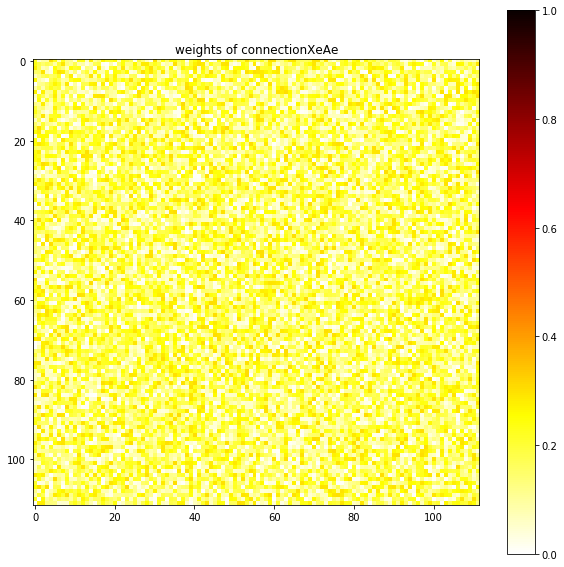

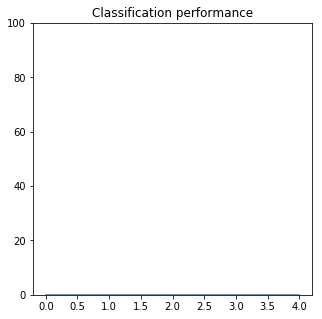

In [27]:
fig_num = 1                                                               # first figure

input_weight_monitor, fig_weights = plot_2d_input_weights(fig_num)        #im show, figure
fig_num += 1
    
# normally done per update interval
performance_monitor, performance, fig_num, fig_performance = plot_performance(fig_num)
fig_num += 1

input_groups['Xe'].rates = 0 * Hz  

net.run(0*second)

In [ ]:
j = 0
while j < (int(num_examples)):                       # 6000
    normalize_weights()                              # normalize XeAe input weights
    spike_rates = training['x'][j%dataset_size,:,:].reshape((n_input)) / 8. *  input_intensity  
    # (28,28) => (784,)      divide by 4.  0>0Hz and 255>64.925Hz     # input_intensity is 2 ???
    
    input_groups['Xe'].rates = spike_rates * Hz                       # input_groups['Xe'] = possion group
    print('run example number:', j+1, 'of', int(num_examples))
    
    net.run(single_example_time, report='text')   # 0.35 s

    if j % update_interval == 0 and j > 0:                            # update_interval is 400
        plot_2d_input_weights(fig_num)
        fig_num += 1
#         assignments = get_new_assignments(result_monitor[:], input_numbers[j-update_interval : j])
        # return (225,) with each n_e is assigned with most spiking digit, according to the result monitor
        
    if j % weight_update_interval == 0:                                    # weight_update_interval 100
        update_2d_input_weights(input_weight_monitor, fig_weights)
        
    if j % save_connections_interval == 0 and j > 0:    # save_connections_interval = 400
        save_connections(str(j))
        save_theta(str(j))

    current_spike_count = np.asarray(spike_counters['Ae'].count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counters['Ae'].count[:])
    
    if np.sum(current_spike_count) < 5:   # if not spiking for this image, increase intensity
        print("only ", np.sum(current_spike_count), " spikes for ", j+1, " th example.")
        
        input_intensity += 1              # why increase intensity ?
        
        input_groups['Xe'].rates = 0 * Hz
        net.run(resting_time)                              # 150 ms
    
    else:                                                   
        result_monitor[j%update_interval,:] = current_spike_count    # update_interval is 400
        input_numbers[j] = training['y'][j%dataset_size][0]
        
#         outputNumbers[j,:] = get_recognized_number_ranking(assignments, result_monitor[j%update_interval,:])
        # for each image, digits are ranked according to most number of spikes
        
        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', int(num_examples))
            
        if j % update_interval == 0 and j > 0:
            unused, performance = update_performance_plot(performance_monitor, performance, j, fig_performance)
            print('Classification performance', performance[:int(j/float(update_interval))+1])
                
        input_groups['Xe'].rates = 0 * Hz
        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1

In [ ]:
save_theta()
save_connections()

In [ ]:
if rate_monitors:
    figure(fig_num, figsize = (10, 10))
    fig_num += 1
    for i, name in enumerate(rate_monitors):
        subplot(len(rate_monitors), 1, 1+i)
        plot(rate_monitors[name].t/second, rate_monitors[name].rate, '.')
        title('Rates of population ' + name)

if spike_monitors:
    figure(fig_num, figsize = (10, 10))
    fig_num += 1
    for i, name in enumerate(spike_monitors):
        subplot(len(spike_monitors), 1, 1+i)
        plot(spike_monitors[name].t/second, spike_monitors[name].i, '.')
        title('Spikes of population ' + name)

if spike_counters:
    figure(fig_num, figsize = (10, 10))
    fig_num += 1
    plot(spike_monitors['Ae'].count[:])
    title('Spike count of population Ae')


In [ ]:
plot_2d_input_weights(fig_num)

plt.figure(5, figsize=(10,10))

subplot(3,1,1)

brian_plot(connections['XeAe'].w)
subplot(3,1,2)

brian_plot(connections['AeAi'].w)

subplot(3,1,3)

brian_plot(connections['AiAe'].w)


plt.figure(6)

subplot(3,1,1)

brian_plot(connections['XeAe'].delay)
subplot(3,1,2)

brian_plot(connections['AeAi'].delay)

subplot(3,1,3)

brian_plot(connections['AiAe'].delay)


b2.ioff()
b2.show()

In [ ]:
fig_num

In [ ]:
plot_2d_input_weights(fig_num+1)

In [ ]:
plt.figure(5, figsize=(10,2))
brian_plot(connections['XeAe'].w)
subplot(1,1,1)

In [28]:
unique(connections['XeAe'].w)

array([0.00300445, 0.00303254, 0.00306284, ..., 0.30294858, 0.30296461,
       0.3029916 ])

In [ ]:
normalize_weights()

In [ ]:
colSums = np.sum(connections['XeAe'], axis = 0)

In [ ]:
colSums